In [19]:
import requests
import json
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from datetime import datetime, timedelta
import time 

URL = "https://www.oref.org.il//Shared/Ajax/GetAlarmsHistory.aspx"
FROM_DATE = '6.10.23'
TO_DATE = '7.10.23'
DAYS_INTERVAL = 1

In [21]:
def get_user_settlement():
    user_settlment = input("Please input the settlement where you would like to map the distribution of alarms\n"
                           "here ---> ")
    return user_settlment

def get_request(current_date, dest_date, alerts_list):
    params = {'lang':'en',
                'fromDate': current_date,
                'toDate': dest_date,
                'mode': '0'}
    response = requests.get(URL, params=params)
    time.sleep(2)
    current_alerts_list = json.loads(response.text)
    alerts_list += current_alerts_list
        

def get_oref_alarms(from_date, to_date):
    all_time_alarams_list = []
    current_date = datetime.strptime(from_date, '%d.%m.%y')
    target_date = datetime.strptime(to_date, '%d.%m.%y')
    print(current_date)
    while current_date <= target_date:
        dest_date = current_date + timedelta(days=DAYS_INTERVAL)  
        get_request(current_date, dest_date, all_time_alarams_list)
        current_date += timedelta(days=DAYS_INTERVAL)
    
    difference = current_date - target_date
    days_diff = difference.days
    day_to_add = DAYS_INTERVAL-days_diff
    current_date -= timedelta(days=DAYS_INTERVAL) # return current_date to the correct date cause we add DAYS_INTERVAL at the end of while loop
    get_request(current_date, current_date + timedelta(days=day_to_add), all_time_alarams_list)
    
    return all_time_alarams_list


In [5]:
def display_dist(df, settlment):
    # Access the 'time' column of the DataFrame
    df['time'] = pd.to_datetime(df['time'])

    # Plot histogram
    plt.hist(df['time'].dt.hour + df['time'].dt.minute / 60, bins=4 * 24, range=(0, 24), color='skyblue', edgecolor='black')

    plt.xlabel('Time')
    plt.ylabel('Alarms')
    plt.title(f"Distribution of alarms in {settlment}")
    # Set X-axis ticks and labels
    plt.xticks(range(24), labels=[str(i) for i in range(24)])
    plt.show()

In [6]:
def return_data_list(dataframe):
    items_lst = [item['data'] for item in dataframe]
    return items_lst


In [7]:
def create_user_settl_lst(given_lst, settlement_name):
    settl_lst = []
    for item in given_lst:
        if settlement_name.lower() in item.lower():
            if item.lower() not in settl_lst:
                settl_lst.append(item.lower())
    return settl_lst

In [8]:
def main():
    try:    
        database = get_oref_alarms(FROM_DATE, TO_DATE)
        print(database)

        data_items_lst = return_data_list(database)
        #print(data_items_lst)

        user_inp = get_user_settlement()
        print(f"You selected: {user_inp}")

        df = pd.DataFrame(database)
        # The user can input values whether they are lowercase or uppercase and it will work fine
        df['data'] = df['data'].str.lower()
        print(df)
        settlement_lst= create_user_settl_lst(data_items_lst, user_inp)
        #print(settlement_lst)
        
        if settlement_lst != []:
            # Filtered the df by the given settlement lst
            filtered_df = df[df['data'].isin(settlement_lst)]
            
            display_dist(filtered_df, user_inp)
    
        else:
            raise ValueError("You selected a Settlement that does not exist.")
        
       
    except ValueError as e:
        print(f"An error occured: {e}")


2023-10-06 00:00:00
[{'data': 'Sderot, Ivim, Nir Am', 'date': '07.10.2023', 'time': '23:42:45', 'alertDate': '2023-10-07T23:43:00', 'category': 1, 'category_desc': 'Missiles', 'matrix_id': 1, 'rid': 20550}, {'data': 'Shokeda', 'date': '07.10.2023', 'time': '23:13:53', 'alertDate': '2023-10-07T23:14:00', 'category': 1, 'category_desc': 'Missiles', 'matrix_id': 1, 'rid': 20549}, {'data': "Be'eri", 'date': '07.10.2023', 'time': '23:13:53', 'alertDate': '2023-10-07T23:14:00', 'category': 1, 'category_desc': 'Missiles', 'matrix_id': 1, 'rid': 20548}, {'data': 'Tkuma', 'date': '07.10.2023', 'time': '22:43:18', 'alertDate': '2023-10-07T22:43:00', 'category': 1, 'category_desc': 'Missiles', 'matrix_id': 1, 'rid': 20547}, {'data': "Tkuma and Havat Izra'am", 'date': '07.10.2023', 'time': '22:43:18', 'alertDate': '2023-10-07T22:43:00', 'category': 1, 'category_desc': 'Missiles', 'matrix_id': 1, 'rid': 20546}, {'data': 'Sharsheret', 'date': '07.10.2023', 'time': '22:43:10', 'alertDate': '2023-10-0

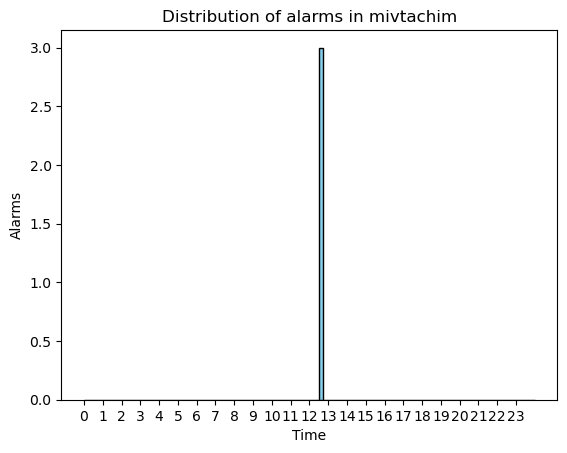

In [22]:
if __name__ == "__main__":
    main()